
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 1 <br>
<font color=696880 size=4>
    Niloufar Abbasi

____

# Emotion Recognition with Recurrent Neural Networks


---

## **Introduction**

In this task, you will implement a Recurrent Neural Network (RNN) to perform tweet emotion recognition. The goal is to classify tweets into one of six basic emotions:
- **0: sadness**
- **1: joy**
- **2: love**
- **3: anger**
- **4: fear**
- **5: surprise**

We will be using a dataset of tweets, where each tweet has been labeled with one of these emotions. Throughout this notebook, you will follow step-by-step instructions to build and train your model. As you progress, you'll complete the provided TODO sections by filling in the necessary code and functions.

By the end of this exercise, you will:
- Understand how to preprocess text data for use in RNN models.
- Build and train a model using Pytorch.
- Evaluate the performance of your model on the test set.

---


---

## Task 1: Enter Your Information

Before we begin, please enter your **student ID** and **name** in the code section below.

Make sure to replace the placeholders with your actual information.

---

In [1]:
#########################################
# TODO: Enter your personal information #
#########################################

student_name = 'Radin Khayyam'  # Replace with your name
student_id   = 99101579  # Replace with your student ID

print("Your name:", student_name)
print("Your student ID:", student_id)

Your name: Radin Khayyam
Your student ID: 99101579


---

## Task 2: Setup and Imports

In this task, we'll be preparing our environment by importing the necessary libraries. Please run the cells below to set everything up. If any library is missing on your end, make sure to install it.

### Instructions:
1. **Run the cells** to install any required packages and import the necessary libraries.
2. If any library is not installed in your environment, use `!pip install <library_name>` to install it.
---

In [ ]:
!pip install datasets
!pip install nlpaug

Required Libraries:

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_dataset
import seaborn as sns
import nlpaug.augmenter.word as naw
import random
import nltk
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score

%matplotlib inline

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### Additional Functions

The following functions have been provided to help you visualize the results of your model training. These will allow you to analyze both the model's performance over time (through the training history) and how well it performs on individual predictions (through a confusion matrix).

1. **`plot_history(hist)`**: This function takes the training history object (`hist`) from your model and plots both the accuracy and loss over the number of epochs for both training and validation sets. It provides an easy way to visually track the model's learning progress and performance.

2. **`visualize_confusion_matrix(actual_labels, predicted_labels, classes)`**: After making predictions with your model, you can use this function to plot a confusion matrix. It shows the accuracy of your model across each class, helping to identify areas where the model is performing well and where it might be struggling. The matrix is normalized to make comparisons easier.

These functions are for your convenience, you can directly use them after running your model to visualize the results.


In [26]:
# Functions to visualize training history and confusion matrix
def plot_history(hist):
    epochs = len(hist['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs), hist['accuracy'], label='Training')
    plt.plot(range(0, epochs), hist['val_accuracy'], label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs), hist['loss'], label='Training')
    plt.plot(range(0, epochs), hist['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize_confusion_matrix(actual_labels, predicted_labels, classes):

    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


---

## Task 3: Importing Data

In this task, we will

- import the Tweet Emotion dataset

- create training, validation, and test sets
    
- extract the tweets and their corresponding labels for further analysis

---

In [7]:
dataset = load_dataset('emotion')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
# Display the first few samples
print(dataset['train'][0:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [9]:
###########################################################################
# TODO: Create variables for the training, validation, and test datasets. #
###########################################################################

training = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [10]:
########################################################################################################
# TODO:                                                                                                #
# Implement the `extract_tweets_labels` function to iterate over the provided dataset.                 #
# Within this function, extract the tweet text and their corresponding labels into two separate lists. #
# Then, call this function with the training dataset to obtain the tweets and labels,                  #
# ensuring proper data handling for subsequent analysis.                                               #
########################################################################################################

def extract_tweets_labels(data):
    # Extract the text and labels from the data
    tweets = [item['text'] for item in data]
    labels = [item['label'] for item in data]
    return tweets, labels

training_tweets, training_labels = extract_tweets_labels(training)
print(training_tweets[0], training_labels[0])


i didnt feel humiliated 0


---

## Task 4: Tokenization of Tweets

In this section, we will focus on the tokenization of the tweets in the dataset. Tokenization is a crucial step in natural language processing (NLP) that involves breaking down text into smaller units, such as words or subwords. This process enables the model to better understand and analyze the text data.

### Objectives:
1. Implement a tokenizer to convert the tweet texts into tokens.
2. Ensure the tokenization process handles various aspects of the text, such as punctuation and special characters.

By the end of this task, you will have a set of tokenized tweets ready for further processing in your NLP pipeline.

---

In [12]:
###############################################################################################################################################
# TODO: Tokenization of Tweets                                                                                                                #
# 1. Select a Tokenization Method: Choose a suitable tokenization method to preprocess the tweets.                                            #
# Ensure that the tokenization handles special characters and maintains the integrity of the text data.                                       #
# 2. Implement the Tokenizer: Once you have selected a method, implement the tokenizer to convert the tweet texts into sequences of tokens.   #
# 3. Test the Tokenization:                                                                                                                   #
# Verify the functionality of your tokenizer by applying it to a sample tweet from the dataset and displaying the resulting tokenized output. #
###############################################################################################################################################

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Test the tokenizer with a sample tweet
sample_tweet = "I love this game! It's amazing, isn't it? #incredible"
print(f"Original Tweet: {sample_tweet}")
print(f"Tokenized Tweet: {tokenizer.tokenize(sample_tweet, add_special_tokens=True)}")
print(f"Encoded Tweet: {tokenizer.encode(sample_tweet, add_special_tokens=True)}")

Keyword arguments {'add_special_tokens': True} not recognized.


Original Tweet: I love this game! It's amazing, isn't it? #incredible
Tokenized Tweet: ['i', 'love', 'this', 'game', '!', 'it', "'", 's', 'amazing', ',', 'isn', "'", 't', 'it', '?', '#', 'incredible']
Encoded Tweet: [101, 1045, 2293, 2023, 2208, 999, 2009, 1005, 1055, 6429, 1010, 3475, 1005, 1056, 2009, 1029, 1001, 9788, 102]


---

## Task 5: Padding and Truncating Sequences

In this task, we will prepare the tokenized tweets for model training by checking their lengths and creating padded sequences.

1. **Checking the Length of the Tweets**
   - Analyze the distribution of tweet lengths to understand the range of token counts in the dataset.

2. **Creating Padded Sequences**
   - After tokenizing the tweets, sequences of different lengths must be adjusted to a uniform length to facilitate training.

---


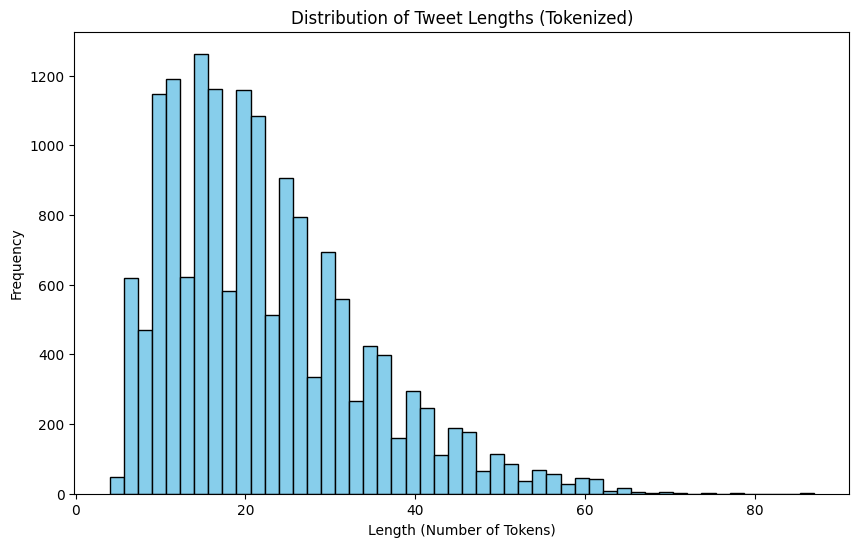

Maximum tweet length: 87


In [13]:
#####################################################################################################################################################
# TODO:                                                                                                                                             #
# Implement code to calculate the lengths of the tweets and visualize the distribution using a histogram. Use an appropriate visualization library. #
# After visualizing the distribution, determine a suitable maximum length for padding and truncating the sequences based on your findings.          #
#####################################################################################################################################################

# Apply the tokenizer to all tweets
tokenized_training_tweets = [tokenizer.encode(tweet, add_special_tokens=True) for tweet in training_tweets]

# Calculate the lengths of the tokenized tweets
tweet_lengths = [len(tweet) for tweet in tokenized_training_tweets]

# Plot a histogram of tweet lengths
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths (Tokenized)')
plt.xlabel('Length (Number of Tokens)')
plt.ylabel('Frequency')
plt.show()

# Get the maximum tweet length
max_length = max(tweet_lengths)
print(f"Maximum tweet length: {max_length}")



In [14]:
############################################################################################################
# TODO: Define a function to convert the tokenized tweets into sequences and apply padding and truncation. #
# Use your determined maximum length for padding the sequences.                                            #
############################################################################################################

def get_sequences(tokenizer, tweets, max_length):
    tokenized_tweets = [tokenizer.encode(tweet, add_special_tokens=True) for tweet in tweets]
    padded_sequences = []
    for tweet in tokenized_tweets:
        # Truncate if tweet is longer than max_length
        if len(tweet) > max_length:
            tweet = tweet[:max_length]
        # Pad if tweet is shorter than max_length
        elif len(tweet) < max_length:
            padding = [0] * (max_length - len(tweet))
            tweet = tweet + padding
        padded_sequences.append(tweet)

    return padded_sequences

max_length = 64
training_sequences = get_sequences(tokenizer, training_tweets, max_length)
print(training_sequences[0])

[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


---

## Task 6: Analyzing Label Distribution

1. Checking the distribution of labels.
2. Addressing any class imbalance using appropriate techniques.

Note:

(**Providing a clear explanation of the chosen method to address the imbalance and how it will improve the model’s performance is critical.** Without handling class imbalance properly, the model could achieve a high accuracy by focusing on the majority class, but it may perform poorly on the minority class, which would result in misleading metrics and reduced generalization.

Hence, it is important to not only implement an appropriate solution but also **justify** why the selected approach is effective for the given task.)

---

<ipython-input-15-52dae6cb55e2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')


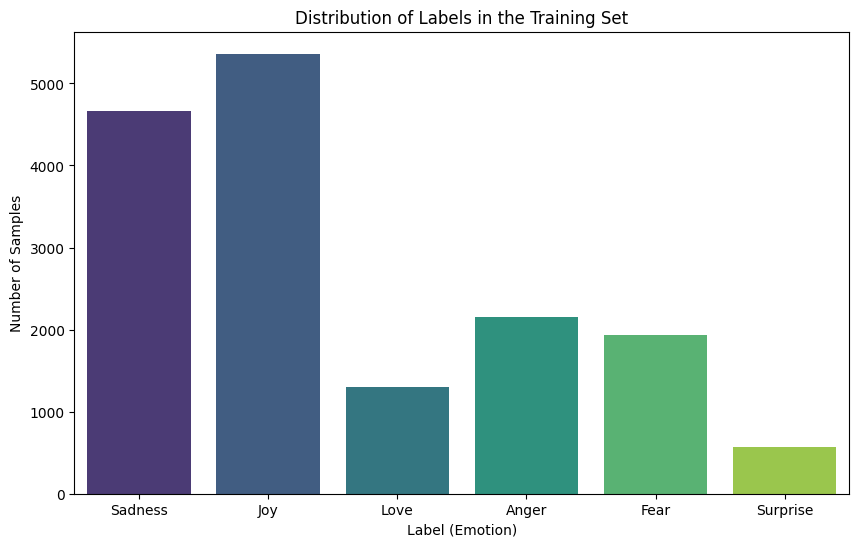

In [15]:
##########################################################################################################################
# TODO: Analyze the distribution of labels in the training set. (visualize it in a perfect way)                          #
# Determine if there is any class imbalance.                                                                             #
# If you observe any imbalance, apply one of the techniques you have learned throughout the course to address the issue. #
##########################################################################################################################

# Count the occurrences of each label
label_counts = {label: training_labels.count(label) for label in set(training_labels)}

# Visualize the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Label (Emotion)')
plt.ylabel('Number of Samples')
plt.xticks(list(label_counts.keys()), ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
plt.show()


In [16]:
# Create the augmenter using WordNet for synonym replacement
aug = naw.SynonymAug(aug_src='wordnet')

# Function to augment a list of tweets
def augment_tweets(tweets, num_times):
    augmented = []
    for tweet in tweets:
        augmented.extend(aug.augment(tweet, n=num_times))
    return augmented

# Collect tweets for specific labels and their required augmentation
label_augmentation_factors = {2: 3, 5: 6, 3: 1, 4: 1}
augmented_tweets = []
augmented_labels = []

for label, factor in label_augmentation_factors.items():

    label_tweets = [tweet for tweet, lbl in zip(training_tweets, training_labels) if lbl == label]
    new_tweets = augment_tweets(label_tweets, factor)
    augmented_tweets.extend(new_tweets)
    augmented_labels.extend([label] * len(new_tweets))

# Add augmented data back to the dataset
training_tweets.extend(augmented_tweets)
training_labels.extend(augmented_labels)

# Shuffle the dataset to ensure the model does not learn the order
combined = list(zip(training_tweets, training_labels))
random.shuffle(combined)
training_tweets, training_labels = zip(*combined)
training_sequences = get_sequences(tokenizer, training_tweets, max_length)
print(f"Augmented training data size: {len(training_tweets)}")

Augmented training data size: 27440


<ipython-input-17-5f5b111f0240>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')


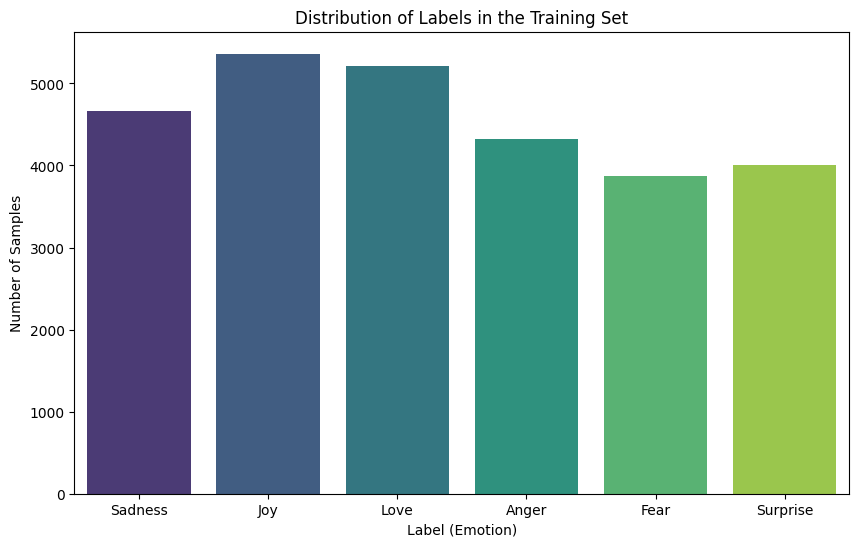

In [17]:
# Count the occurrences of each label
label_counts = {label: training_labels.count(label) for label in set(training_labels)}

# Visualize the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Label (Emotion)')
plt.ylabel('Number of Samples')
plt.xticks(list(label_counts.keys()), ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
plt.show()

To address the class imbalance in our dataset, we employed data augmentation strategies specifically targeted at underrepresented classes. This was achieved through synonym replacement using the **nlpaug** library, which integrates with WordNet via NLTK to perform the augmentation. By selecting the classes "Love," "Surprise," "Anger," and "Fear," which were less represented compared to "Joy" and "Sadness," we tailored our augmentation efforts to enhance their sample size effectively. For "Love" and "Surprise," the number of samples was increased fourfold, while for "Anger" and "Fear," the samples were doubled. This augmentation process involved generating new tweets by substituting some words in the original texts with their synonyms, thereby creating similar yet distinct training examples.

The augmentation was meticulously implemented to ensure the semantic integrity of the tweets remained intact. Each tweet selected for augmentation was processed to generate multiple variants, adhering to the predefined multiplication factor for each class. These synthetic tweets were then reintegrated into the original dataset, keeping their corresponding emotional labels consistent with the original texts. This process not only increased the volume of data but also introduced a diversity of linguistic expressions within the same emotional context. To prevent any order bias that might influence the model during training, the expanded dataset was thoroughly shuffled after the augmentation process.

The impact of this data augmentation on the training of the model was multifaceted. Primarily, it addressed the imbalance by equalizing the representation across all classes, thus preventing the model from overfitting to the more frequent classes. This balanced dataset helped the model learn more generalized features across different emotions, enhancing its ability to correctly classify new, unseen data. Furthermore, by diversifying the training examples within each class, the model's robustness was significantly improved, making it better equipped to handle variations in real-world data. Overall, this approach not only boosted the quantitative balance of the training set but also qualitatively enriched the data, which is crucial for maintaining high accuracy and fairness in emotion recognition tasks.

---

## Task 7: Creating the Model

Design and implement a recurrent neural network for the task. You may utilize a sequential architecture like RNN or GRU to enhance the model's performance.

Build and compile your model using Pytorch.

**Once the model is created, summarize its structure to verify the design.**

---

In [18]:
#########################################################################################################
# TODO:                                                                                                 #
# Create a recurrent neural network model for the task.                                                 #
# (Suggestion: Implement a Bidirectional LSTM architecture to process the input sequences effectively.) #
# Once the model is created, summarize its structure to verify the design.                              #
#########################################################################################################

class EmotionRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super(EmotionRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout=dropout,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # Text input is [batch size, sent_length]
        embedded = self.dropout(self.embedding(text))

        # Embedded is [batch size, sent_length, emb_dim]
        output, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final forward and backward hidden state
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        # Hidden [batch size, hid_dim * num directions]
        dense_outputs = self.fc(self.dropout(hidden))

        return dense_outputs

# Hyperparameters
vocab_size = tokenizer.vocab_size
embedding_dim = 100
hidden_dim = 256
output_dim = 6
num_layers = 2
bidirectional = True
dropout = 0.5

# Instantiate the model
model = EmotionRNN(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

EmotionRNN(
  (embedding): Embedding(30522, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


---

## Task 8: Training the Model

In this task, you will prepare a validation set and train your model using the training data.

1. Prepare the validation set by extracting tweets and labels, and convert them into sequences using the tokenizer.
2. Train the model on the training data.
3. Ensure that you implement **Early Stopping** to prevent overfitting and enhance efficiency.

Make sure to monitor the validation accuracy during training and adjust the parameters as necessary.

---

In [19]:
###############################################################################################################
# TODO: Extract the tweets and labels from the validation set. Convert the tweets into sequences using the    #
#       tokenizer defined earlier. Prepare the data for validation and ensure it matches the format of the    #
#       training set.                                                                                         #
###############################################################################################################

# Extract tweets and labels from datasets
validation_tweets, validation_labels = extract_tweets_labels(validation)

# Tokenize and pad sequences
max_length = 64
validation_sequences = get_sequences(tokenizer, validation_tweets, max_length)

# Convert sequences and labels to tensors
train_sequences_tensor = torch.tensor(training_sequences, dtype=torch.long)
train_labels_tensor = torch.tensor(training_labels, dtype=torch.long)

validation_sequences_tensor = torch.tensor(validation_sequences, dtype=torch.long)
validation_labels_tensor = torch.tensor(validation_labels, dtype=torch.long)

# Create TensorDataset
train_data = TensorDataset(train_sequences_tensor, train_labels_tensor)
validation_data = TensorDataset(validation_sequences_tensor, validation_labels_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [20]:
###############################################################################################################
# TODO: Train the model on the prepared training data. Ensure you implement early stopping to monitor the     #
#       validation accuracy and prevent overfitting. Adjust the number of epochs or other hyperparameters as  #
#       needed to optimize model performance.                                                                 #
###############################################################################################################

# Early stopping utility class
class EarlyStopping:
    def __init__(self, patience=7, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Save model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} to {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'best_model.pth')
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=5)

history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_losses, train_accuracies = [], []

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        predictions = outputs.argmax(dim=1)
        train_accuracies.append(accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy()))

    # Record the average training loss and accuracy for this epoch
    history['loss'].append(np.mean(train_losses))
    history['accuracy'].append(np.mean(train_accuracies))

    # Evaluate on validation set
    model.eval()
    val_losses, val_accuracies = [], []
    with torch.no_grad():
        for texts, labels in validation_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

            predictions = outputs.argmax(dim=1)
            val_accuracies.append(accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy()))

    history['val_loss'].append(np.mean(val_losses))
    history['val_accuracy'].append(np.mean(val_accuracies))

    print(f'Epoch {epoch + 1}: Train Loss: {history["loss"][-1]:.4f}, Train Accuracy: {history["accuracy"][-1]:.4f}, Val Loss: {history["val_loss"][-1]:.4f}, Val Accuracy: {history["val_accuracy"][-1]:.4f}')

    # Early stopping check
    early_stopping(np.mean(val_losses), model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load('best_model.pth'))

Epoch 1: Train Loss: 1.6308, Train Accuracy: 0.3041, Val Loss: 1.3849, Val Accuracy: 0.4410
Validation loss decreased (inf to 1.384904). Saving model...
Epoch 2: Train Loss: 1.2504, Train Accuracy: 0.5069, Val Loss: 0.8131, Val Accuracy: 0.7242
Validation loss decreased (1.384904 to 0.813137). Saving model...
Epoch 3: Train Loss: 0.8650, Train Accuracy: 0.6845, Val Loss: 0.4432, Val Accuracy: 0.8373
Validation loss decreased (0.813137 to 0.443162). Saving model...
Epoch 4: Train Loss: 0.6215, Train Accuracy: 0.7802, Val Loss: 0.2956, Val Accuracy: 0.8805
Validation loss decreased (0.443162 to 0.295623). Saving model...
Epoch 5: Train Loss: 0.4961, Train Accuracy: 0.8244, Val Loss: 0.2300, Val Accuracy: 0.9023
Validation loss decreased (0.295623 to 0.229956). Saving model...
Epoch 6: Train Loss: 0.4086, Train Accuracy: 0.8555, Val Loss: 0.1845, Val Accuracy: 0.9191
Validation loss decreased (0.229956 to 0.184528). Saving model...
Epoch 7: Train Loss: 0.3552, Train Accuracy: 0.8728, Val 

<ipython-input-20-46543c8b9d31>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

---

## Task 9: Evaluating the Model

In this task, you will evaluate the performance of your model on the test set and visualize the training history. You will also analyze the model’s predictions on both individual and complete test samples.

### Steps:
1. Visualize the loss and accuracy over the training epochs.
2. Prepare and preprocess the test data using functions from Task 2.
3. Evaluate the model on the test set and examine individual predictions.
4. Analyze the overall predictions and display a confusion matrix.

---

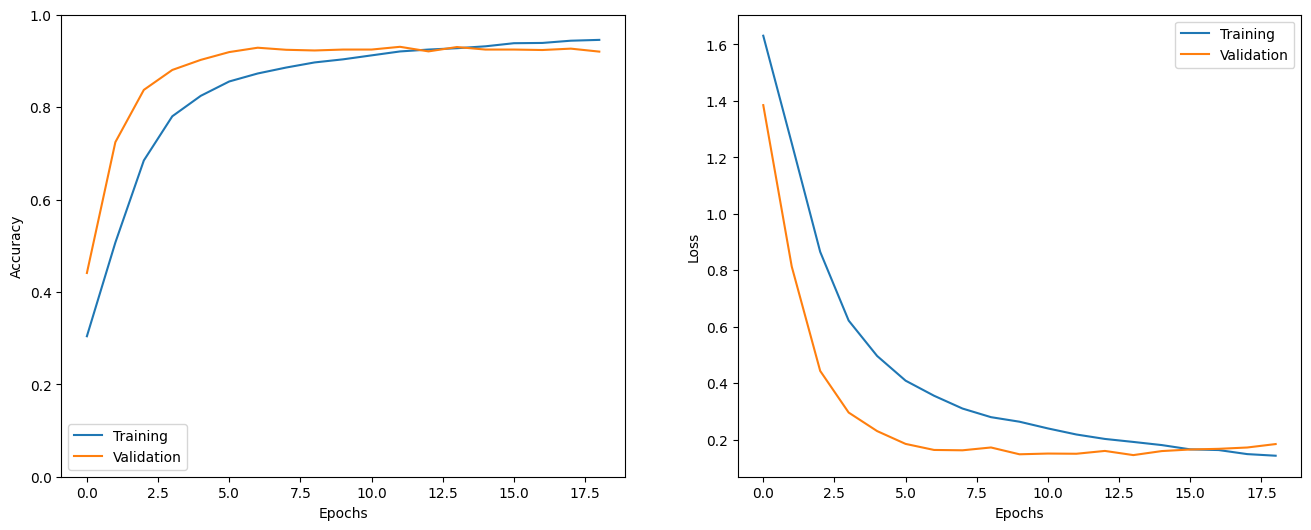

In [27]:
###############################################################################################################
# TODO: Visualize the training history by plotting the loss and accuracy over the epochs to assess model      #
#       performance. Use an appropriate visualization method to ensure clarity and effectiveness.             #
#       you can use function implemented in Task 2 for your visualizations                                    #
###############################################################################################################

plot_history(history)

In [28]:
###############################################################################################################
# TODO: Prepare the test set by extracting the tweets and labels, then convert the tweets into sequences using #
#       the tokenizer. Ensure the format matches that of the training and validation sets.                     #
###############################################################################################################

# Extract tweets and labels from datasets
test_tweets, test_labels = extract_tweets_labels(test)

# Tokenize and pad sequences
max_length = 64
test_sequences = get_sequences(tokenizer, test_tweets, max_length)

# Convert sequences and labels to tensors
test_sequences_tensor = torch.tensor(test_sequences, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset
test_data = TensorDataset(test_sequences_tensor, test_labels_tensor)

# Create DataLoader
batch_size = 32
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)



In [29]:
###############################################################################################################
# TODO: Evaluate the model's performance on the test set. Print the accuracy and loss, and review individual   #
#       predictions to understand how the model is performing on unseen data.                                 #
###############################################################################################################

model.eval()
criterion = nn.CrossEntropyLoss()
true_labels = []
predictions = []

with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Extend the lists for true labels and predictions
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Calculate and print the average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')



Test Loss: 0.1530, Test Accuracy: 0.9220


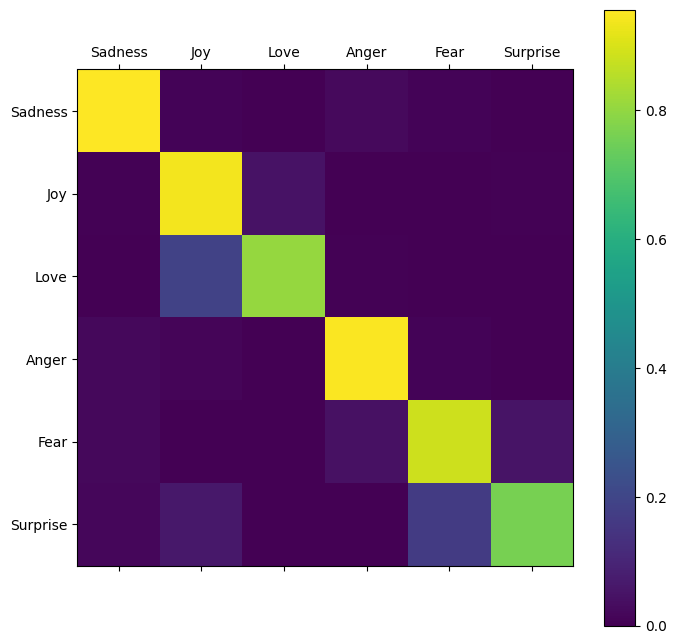

In [30]:
###############################################################################################################
# TODO: Generate predictions for all test samples and analyze the model's overall performance. Display the     #
#       confusion matrix to visualize the differences between true and predicted labels, helping to interpret  #
#       the model's classification results.                                                                   #
###############################################################################################################
class_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
visualize_confusion_matrix(true_labels, predictions, class_names)

# Final Analysis

After visualizing the confusion matrix based on your model’s predictions, analyze the results and provide insights into the model’s classification performance.

### **Question:**
<span style="font-size: 1.2em;">Which class seems to get confused with the class *love* the most?</span>

**Remember the class labels:**
- **0:** *Sadness*
- **1:** *Joy*
- **2:** *Love*
- **3:** *Anger*
- **4:** *Fear*
- **5:** *Surprise*

Reflect on the confusion matrix to answer this question and provide your reasoning for why this confusion might occur based on the emotional nature of the classes.

---

Based on the confusion matrix, the class that seems to get confused with *Love* the most is *Joy*. In the confusion matrix, the cell at the intersection of the *Love* row and *Joy* column is notably lighter in color compared to other cells in the *Love* row, indicating a higher rate of misclassification of *Love* as *Joy*.

### Reasoning for Confusion Between Love and Joy:
The likely reason for this confusion stems from the emotional similarity between *Love* and *Joy*. Both emotions are positive and often elicit similar types of expressions and language. Here are some factors that might contribute to this confusion:

1. **Overlap in Expression**: Expressions of *Love* and *Joy* can be very similar, often involving positive language, emotive adjectives, and expressions of affection or happiness. This overlap can make it difficult for the model to distinguish between them purely based on text.

2. **Semantic Similarity**: The words used to describe experiences or feelings related to *Love* and *Joy* can be semantically similar. For instance, sentences like "I'm overjoyed at your success" and "I love your success" share a positive sentiment and could use similar vocabulary.

Improving the model's ability to distinguish between these two could involve better feature engineering to capture emotional nuances, using more advanced natural language processing techniques, or providing the model with a more balanced and representative training dataset.

# **Best regards.**